# Regress Litter on Deprivation in Glasgow City

## Load Data

In [30]:
import pandas as pd

data_fpath = "../glasgow-simd2020v2.csv"

df = pd.read_csv(data_fpath, header=0)
n_rows = len(df.index)
n_columns = len(df.columns)

print(f"There are {n_rows} observations and {n_columns} features.")
print("The features are:", end="\n\n")
for i, feature in enumerate(df.columns.values):
  print(f"{i+1}. {feature}")

There are 746 observations and 50 features.
The features are:

1. Data_Zone
2. Intermediate_Zone
3. Council_area
4. Total_population
5. Working_Age_population
6. SIMD2020v2_Rank
7. SIMD_2020v2_Percentile
8. SIMD2020v2_Vigintile
9. SIMD2020v2_Decile
10. SIMD2020v2_Quintile
11. SIMD2020v2_Income_Domain_Rank
12. SIMD2020_Employment_Domain_Rank
13. SIMD2020_Health_Domain_Rank
14. SIMD2020_Education_Domain_Rank
15. SIMD2020_Access_Domain_Rank
16. SIMD2020_Crime_Domain_Rank
17. SIMD2020_Housing_Domain_Rank
18. income_rate
19. income_count
20. employment_rate
21. employment_count
22. CIF
23. ALCOHOL
24. DRUG
25. SMR
26. DEPRESS
27. LBWT
28. EMERG
29. Attendance
30. Attainment
31. no_qualifications
32. not_participating
33. University
34. crime_count
35. crime_rate
36. overcrowded_count
37. nocentralheating_count
38. overcrowded_rate
39. nocentralheating_rate
40. drive_petrol
41. drive_GP
42. drive_post
43. drive_primary
44. drive_retail
45. drive_secondary
46. PT_GP
47. PT_post
48. PT_retail


## Handle Missing Data

In [31]:
import numpy as np

def print_missing_data_count(df):
  missing_data = df[df.isnull().any(axis=1)]
  missing_data_rows = len(missing_data)
  print(f"There are {missing_data_rows} observations with missing data.")

df = df.replace("*", np.NaN)
print_missing_data_count(df)

df = df.fillna(0)
print_missing_data_count(df)

There are 105 observations with missing data.
There are 0 observations with missing data.


## Inspect Feature Data Types

In [32]:
df.dtypes

Data_Zone                           object
Intermediate_Zone                   object
Council_area                        object
Total_population                     int64
Working_Age_population               int64
SIMD2020v2_Rank                      int64
SIMD_2020v2_Percentile               int64
SIMD2020v2_Vigintile                 int64
SIMD2020v2_Decile                    int64
SIMD2020v2_Quintile                  int64
SIMD2020v2_Income_Domain_Rank      float64
SIMD2020_Employment_Domain_Rank    float64
SIMD2020_Health_Domain_Rank          int64
SIMD2020_Education_Domain_Rank       int64
SIMD2020_Access_Domain_Rank          int64
SIMD2020_Crime_Domain_Rank         float64
SIMD2020_Housing_Domain_Rank       float64
income_rate                         object
income_count                         int64
employment_rate                     object
employment_count                     int64
CIF                                float64
ALCOHOL                            float64
DRUG       

In [33]:
to_category_features = ["Data_Zone", "Intermediate_Zone", "Council_area"]
for feature in to_category_features:
  df[feature] = df[feature].astype("category")

to_float_features = [
  "income_rate",
  "employment_rate",
  "crime_rate",
  "DEPRESS",
  "LBWT",
  "Attendance",
  "not_participating",
  "University",
  "overcrowded_rate",
  "nocentralheating_rate",
  "broadband",
  "crime_count",
  "Attainment"
]
for feature in to_float_features:
  df[feature] = df[feature].str.rstrip("%").astype(float) / 100

df.dtypes

Data_Zone                          category
Intermediate_Zone                  category
Council_area                       category
Total_population                      int64
Working_Age_population                int64
SIMD2020v2_Rank                       int64
SIMD_2020v2_Percentile                int64
SIMD2020v2_Vigintile                  int64
SIMD2020v2_Decile                     int64
SIMD2020v2_Quintile                   int64
SIMD2020v2_Income_Domain_Rank       float64
SIMD2020_Employment_Domain_Rank     float64
SIMD2020_Health_Domain_Rank           int64
SIMD2020_Education_Domain_Rank        int64
SIMD2020_Access_Domain_Rank           int64
SIMD2020_Crime_Domain_Rank          float64
SIMD2020_Housing_Domain_Rank        float64
income_rate                         float64
income_count                          int64
employment_rate                     float64
employment_count                      int64
CIF                                 float64
ALCOHOL                         

## Summarise

In [34]:
df.describe()

,Total_population,Working_Age_population,SIMD2020v2_Rank,SIMD_2020v2_Percentile,SIMD2020v2_Vigintile,SIMD2020v2_Decile,SIMD2020v2_Quintile,SIMD2020v2_Income_Domain_Rank,SIMD2020_Employment_Domain_Rank,SIMD2020_Health_Domain_Rank,...,drive_GP,drive_post,drive_primary,drive_retail,drive_secondary,PT_GP,PT_post,PT_retail,broadband,litter
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,...,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000,744.000000,746.000000
mean,832.466488,587.012064,2356.975871,34.282842,7.269437,3.912869,2.262735,2210.412198,2429.540214,2223.316354,...,2.346055,2.346497,2.630558,3.539734,4.231587,7.098030,7.079232,9.656767,0.015538,61.147453
std,249.111693,226.292407,2083.181465,29.850575,5.959690,2.947263,1.425795,1970.824622,2075.072254,2041.083778,...,1.045879,0.829226,0.889530,1.332983,1.337981,3.066340,2.520782,3.464514,0.050950,28.197715
min,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.664751,0.667906,0.979924,0.843476,1.290801,1.595565,1.831674,2.289857,0.000000,9.000000
25%,683.500000,450.250000,500.250000,8.000000,2.000000,1.000000,1.000000,479.250000,557.000000,425.500000,...,1.568119,1.732829,1.999866,2.622112,3.239094,4.859224,5.281409,7.071742,0.000000,41.000000
50%,808.500000,552.000000,1690.000000,25.000000,5.000000,3.000000,2.000000,1554.500000,1887.000000,1553.500000,...,2.122786,2.242858,2.507080,3.392009,4.081267,6.719505,6.792529,9.250142,0.000000,56.000000
75%,939.000000,669.000000,4048.500000,58.750000,12.000000,6.000000,3.000000,3712.250000,4120.500000,3659.750000,...,2.976169,2.871751,3.084471,4.388052,5.065079,8.865254,8.518213,11.827786,0.000000,77.750000
max,2544.000000,2361.000000,6956.000000,100.000000,20.000000,10.000000,5.000000,6969.000000,6974.000000,6976.000000,...,6.904760,5.201232,6.935962,8.521768,8.467000,21.908923,16.288734,23.645457,0.490000,179.000000


## Split Data

In [35]:
df_train, df_valid, df_test = np.split(df.sample(frac=1, random_state=1), [int(.7*len(df)), int(.9*len(df))])

print("Training data: {} observations".format(len(df_train)))
print("Validation data: {} observations".format(len(df_valid)))
print("Test data: {} observations".format(len(df_test)))

Training data: 522 observations
Validation data: 149 observations
Test data: 75 observations


## Model 1: Poisson (All Features)

### Train

In [36]:
from patsy import dmatrices
import statsmodels.api as sm

model_expr = "litter ~ Total_population + Working_Age_population + income_rate + income_count + employment_rate + employment_count + CIF + ALCOHOL + DRUG + SMR + DEPRESS + LBWT + EMERG + Attendance + Attainment + no_qualifications + not_participating + University + crime_count + crime_rate + overcrowded_rate + nocentralheating_rate + drive_petrol + drive_GP + drive_post + drive_primary + drive_retail + drive_secondary + PT_GP + PT_post + PT_retail + broadband"

y_train, X_train = dmatrices(model_expr, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(model_expr, df_valid, return_type="dataframe")

model_train = sm.GLM(y_train, X_train, family=sm.families.Poisson())
results_train = model_train.fit()

model_lambda = results_train.mu

results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 litter   No. Observations:                  454
Model:                            GLM   Df Residuals:                      421
Model Family:                 Poisson   Df Model:                           32
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3113.3
Date:                Mon, 03 Jan 2022   Deviance:                       3553.4
Time:                        14:40:55   Pearson chi2:                 3.62e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9886
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.5034      0.149     30.248      0.000       4.212       4.795
Total_population          -0.0005      0.000     -2.475      0.013      -0.001   -9.39e-05
Working_Age_population     0.0003      0.000      1.540      0.124   -7.69e-05       0.001
income_rate                0.3010      0.573      0.526      0.599      -0.822       1.424
income_count               0.0026      0.001      3.777      0.000       0.001       0.004
employment_rate            3.1594      0.617      5.118      0.000       1.949       4.369
employment_count          -0.0067      0.001     -6.191      0.000      -0.009      -0.005
CIF                       -0.0013      0.000     -3.560      0.000      -0.002      -0.001
ALCOHOL                 8.246e-05   7.91e-05      1.042      0.297   -7.26e-05       0.000
DRUG                      -0.0001   5.69e-05     -2.144      0.032      -0.000   -1.05e-05
SMR                        0.0003      0.000      2.377      0.017    4.94e-05       0.001
DEPRESS                   -0.5988      0.222     -2.700      0.007      -1.033      -0.164
LBWT                       0.6526      0.139      4.684      0.000       0.379       0.926
EMERG                     -0.0002      0.000     -0.707      0.479      -0.001       0.000
Attendance                -0.5736      0.111     -5.180      0.000      -0.791      -0.357
Attainment                 4.2473      1.860      2.284      0.022       0.602       7.892
no_qualifications          0.0004      0.000      1.611      0.107   -8.46e-05       0.001
not_participating          0.0354      0.217      0.163      0.870      -0.390       0.461
University                -0.2951      0.168     -1.752      0.080      -0.625       0.035
crime_count                0.5677      0.115      4.940      0.000       0.342       0.793
crime_rate                -0.0551      0.010     -5.747      0.000      -0.074      -0.036
overcrowded_rate           0.8395      0.114      7.336      0.000       0.615       1.064
nocentralheating_rate     -0.2646      0.267     -0.990      0.322      -0.788       0.259
drive_petrol              -0.0712      0.006    -11.342      0.000      -0.083      -0.059
drive_GP                   0.0135      0.014      0.949      0.342      -0.014       0.041
drive_post                -0.0295      0.015     -1.932      0.053      -0.059       0.000
drive_primary             -0.0117      0.009     -1.323      0.186      -0.029       0.006
drive_retail               0.0161      0.009      1.831      0.067      -0.001       0.033
drive_secondary            0.0265      0.005      5.597      0.000       0.017       0.036
PT_GP                     -0.0032      0.005     -0.637      0.524      -0.013       0.007
PT_post                   -0.0107      0.005     -2.098      0.036      -0.021  

### Predict

In [37]:
predictions = results_train.get_prediction(X_valid)
df_predictions = predictions.summary_frame()
predicted_counts, actual_counts = round(df_predictions["mean"]), y_valid["litter"]

print(predicted_counts)

326    50.0
458    80.0
465    61.0
167    52.0
145    53.0
       ... 
243    55.0
87     70.0
678    77.0
418    50.0
288    82.0
Name: mean, Length: 123, dtype: float64


### Evaluate

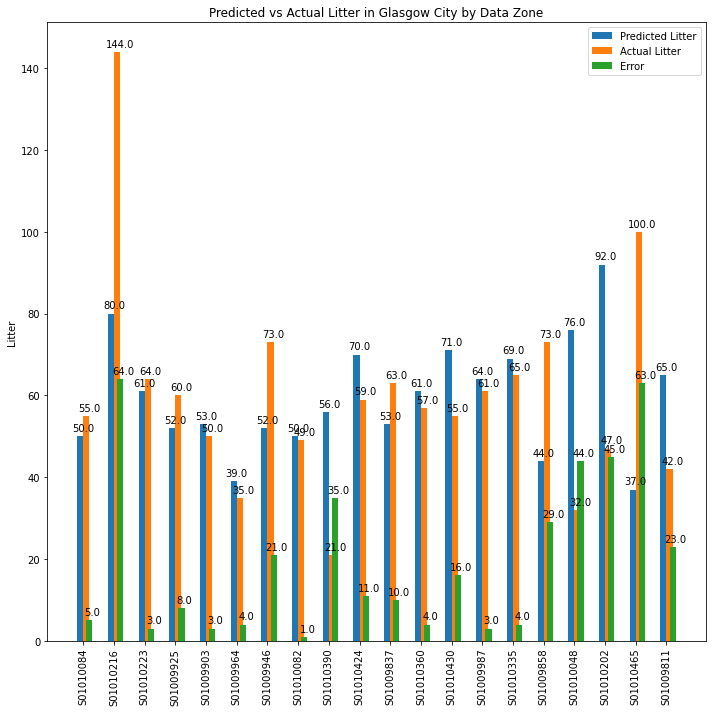

In [38]:
import matplotlib.pyplot as plt

n_bars = 20
indices = X_valid.index[:n_bars]
labels = df.iloc[indices]["Data_Zone"]
y_predicted = predicted_counts[:n_bars]
y_actual = actual_counts[:n_bars]
y_err = abs(y_predicted - y_actual)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
x = np.arange(len(labels))
bar_width = 0.2
rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter")
rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter")
rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error")
ax.set_ylabel("Litter")
ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height}",
            xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center", va='bottom'
        )

fig.tight_layout()
plt.show()

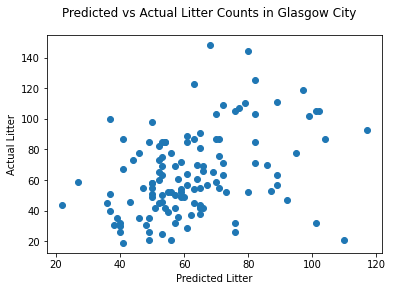

In [39]:
fig.clear()

fig = plt.figure()
fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
plt.scatter(x=predicted_counts, y=actual_counts)
plt.xlabel("Predicted Litter")
plt.ylabel("Actual Litter")
plt.show()

## Model 2: Poisson (Significant Features)

In [40]:
model_expr = "litter ~ Total_population + Working_Age_population + income_count + employment_rate + employment_count + SMR + University + crime_count + crime_rate + overcrowded_rate + drive_petrol + drive_primary + drive_secondary + PT_post + broadband"

y_train, X_train = dmatrices(model_expr, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(model_expr, df_valid, return_type="dataframe")

model_train = sm.GLM(y_train, X_train, family=sm.families.Poisson())
results_train = model_train.fit()

model_lambda = results_train.mu

results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 litter   No. Observations:                  518
Model:                            GLM   Df Residuals:                      502
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3623.3
Date:                Mon, 03 Jan 2022   Deviance:                       4213.6
Time:                        14:40:56   Pearson chi2:                 4.33e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9865
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4.0257      0.055     73.130      0.000       3.918       4.134
Total_population          -0.0004      0.000     -3.540      0.000      -0.001      -0.000
Working_Age_population     0.0003      0.000      2.729      0.006    8.85e-05       0.001
income_count               0.0029      0.000     12.017      0.000       0.002       0.003
employment_rate            2.2323      0.205     10.882      0.000       1.830       2.634
employment_count          -0.0068      0.000    -14.364      0.000      -0.008      -0.006
SMR                        0.0001      0.000      1.337      0.181   -6.45e-05       0.000
University                -0.6677      0.123     -5.434      0.000      -0.909      -0.427
crime_count                0.2075      0.073      2.859      0.004       0.065       0.350
crime_rate                -0.0216      0.006     -3.395      0.001      -0.034      -0.009
overcrowded_rate           1.0376      0.085     12.149      0.000       0.870       1.205
drive_petrol              -0.0558      0.005    -10.895      0.000      -0.066      -0.046
drive_primary              0.0050      0.007      0.682      0.496      -0.009       0.019
drive_secondary            0.0153      0.004      3.584      0.000       0.007       0.024
PT_post                   -0.0165      0.002     -6.607      0.000      -0.021      -0.012
broadband                  0.1411      0.139      1.013      0.311      -0.132       0.414
==========================================================================================
"""

In [41]:
predictions = results_train.get_prediction(X_valid)
df_predictions = predictions.summary_frame()
predicted_counts, actual_counts = round(df_predictions["mean"]), y_valid["litter"]

print(predicted_counts)

326    54.0
458    76.0
465    69.0
163    56.0
167    54.0
       ... 
87     71.0
655    40.0
678    77.0
418    54.0
288    85.0
Name: mean, Length: 147, dtype: float64


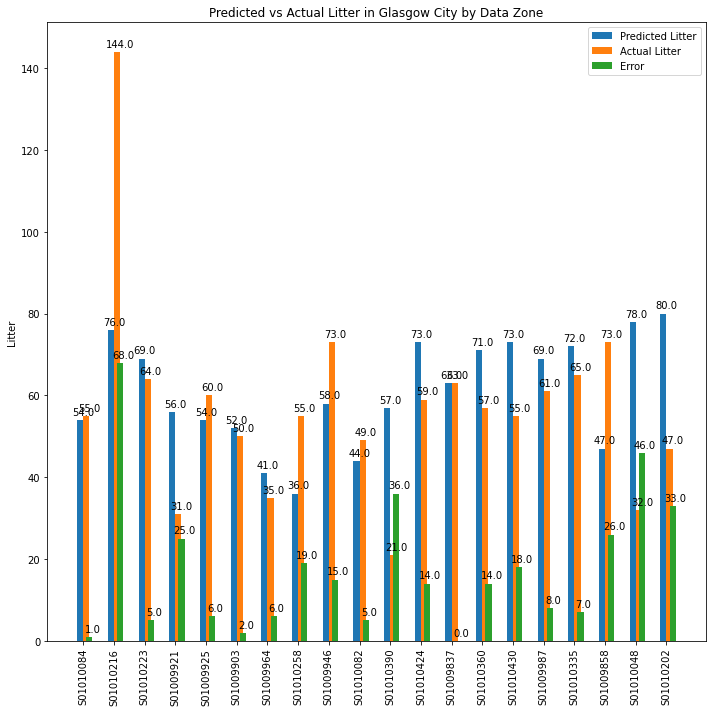

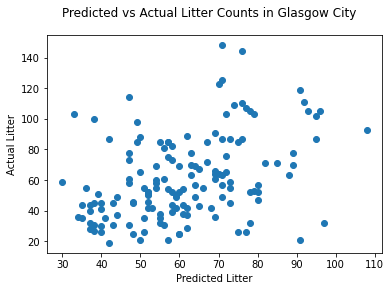

In [42]:
n_bars = 20
indices = X_valid.index[:n_bars]
labels = df.iloc[indices]["Data_Zone"]
y_predicted = predicted_counts[:n_bars]
y_actual = actual_counts[:n_bars]
y_err = abs(y_predicted - y_actual)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
x = np.arange(len(labels))
bar_width = 0.2
rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter")
rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter")
rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error")
ax.set_ylabel("Litter")
ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height}",
            xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center", va='bottom'
        )

fig.tight_layout()
plt.show()

fig.clear()

fig = plt.figure()
fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
plt.scatter(x=predicted_counts, y=actual_counts)
plt.xlabel("Predicted Litter")
plt.ylabel("Actual Litter")
plt.show()

## Model 3: Negative Binomial (NB2)

In [43]:
import statsmodels.formula.api as smf

df_train_nb = df_train.copy()
df_train_nb = df_train.loc[X_train.index]

df_train_nb["litter_lambda"] = model_lambda
df_train_nb["aux_ols_dep"] = df_train_nb.apply(lambda x: ((x["litter"] - x["litter_lambda"])**2 - x["litter_lambda"]) / x["litter_lambda"], axis=1)

aux_olsr_results = smf.ols("aux_ols_dep ~ litter_lambda - 1", df_train_nb).fit()
print(aux_olsr_results.params)
print(aux_olsr_results.tvalues)

litter_lambda    0.120703
dtype: float64
litter_lambda    12.622592
dtype: float64


In [44]:
#model_expr = "litter ~ Total_population + Working_Age_population + income_rate + income_count + employment_rate + employment_count + CIF + ALCOHOL + DRUG + SMR + DEPRESS + LBWT + EMERG + Attendance + Attainment + no_qualifications + not_participating + University + crime_count + crime_rate + overcrowded_rate + nocentralheating_rate + drive_petrol + drive_GP + drive_post + drive_primary + drive_retail + drive_secondary + PT_GP + PT_post + PT_retail + broadband"
#model_expr = "litter ~ ALCOHOL + no_qualifications + drive_primary"
model_expr = "litter ~ overcrowded_rate + drive_primary"

y_train, X_train = dmatrices(model_expr, df_train, return_type="dataframe")
y_valid, X_valid = dmatrices(model_expr, df_valid, return_type="dataframe")

alpha = aux_olsr_results.params["litter_lambda"]
#alpha = 0.1

model_train = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha))
results_train = model_train.fit()

results_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 litter   No. Observations:                  522
Model:                            GLM   Df Residuals:                      519
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2408.3
Date:                Mon, 03 Jan 2022   Deviance:                       684.66
Time:                        14:40:57   Pearson chi2:                     694.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1933
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.8006      0.067     57.066      0.000       3.670       3.931
overcrowded_rate     1.9372      0.180     10.737      0.000       1.584       2.291
drive_primary       -0.0431      0.018     -2.341      0.019      -0.079      -0.007
====================================================================================
"""

In [45]:
predictions = results_train.get_prediction(X_valid)
df_predictions = predictions.summary_frame()
predicted_counts, actual_counts = round(df_predictions["mean"]), y_valid["litter"]

print(predicted_counts)

326    58.0
458    58.0
465    54.0
163    56.0
167    66.0
       ... 
87     91.0
655    42.0
678    74.0
418    58.0
288    58.0
Name: mean, Length: 149, dtype: float64


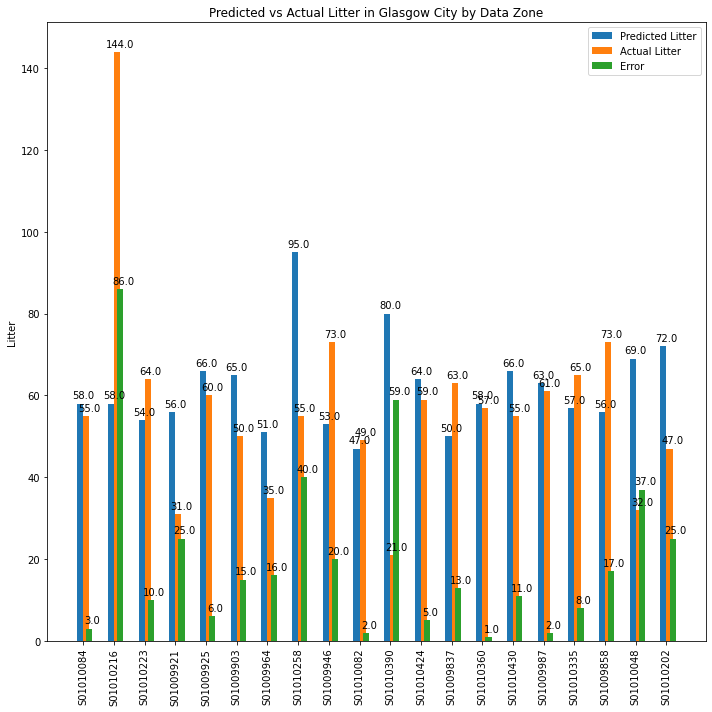

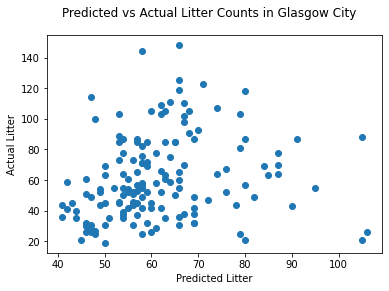

In [46]:
import matplotlib.pyplot as plt

n_bars = 20
indices = X_valid.index[:n_bars]
labels = df.iloc[indices]["Data_Zone"]
y_predicted = predicted_counts[:n_bars]
y_actual = actual_counts[:n_bars]
y_err = abs(y_predicted - y_actual)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
x = np.arange(len(labels))
bar_width = 0.2
rects1 = ax.bar(x - bar_width/2, y_predicted, bar_width, label="Predicted Litter")
rects2 = ax.bar(x + bar_width/2, y_actual, bar_width, label="Actual Litter")
rects3 = ax.bar(x + (bar_width/2) + (bar_width/2), y_err, bar_width, label="Error")
ax.set_ylabel("Litter")
ax.set_title("Predicted vs Actual Litter in Glasgow City by Data Zone")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height}",
            xy=(rect.get_x() + rect.get_width() / 2 + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center", va='bottom'
        )

fig.tight_layout()
plt.show()

fig.clear()

fig = plt.figure()
fig.suptitle("Predicted vs Actual Litter Counts in Glasgow City")
plt.scatter(x=predicted_counts, y=actual_counts)
plt.xlabel("Predicted Litter")
plt.ylabel("Actual Litter")
plt.show()